# Usage
This file is the main file used to analyse WhatsApp messages. If you have very little coding experience, simply rename the 'filename' variable below and then run all of the cells and explore the output.

In [168]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import emoji

In [169]:
# Edit the 'filename' variable below to fit your file name
filename = 'WhatsApp Chat.txt'
with open(filename, encoding="utf8") as file:
    data = [line.rstrip() for line in file]

# Setup
The main code is stored here, which is the building blocks for the analysis. There are two main classes, 'Conversation' and 'Message'. Each conversation stores a set of 'Message' objects which contains all relevant attributes.

In [170]:
class Message:
    def __init__(self, content): # sender, date, time, length,
        self.content = content
        self.datetime = self.get_datetime()
        self.date = self.datetime.date()
        self.time = self.datetime.time()
        self.hour = self.datetime.hour
        self.sender = self.get_sender()
        self.length = self.get_length()
        self.message_start_pos = self.get_message_start_pos()
        self.message = self.content[self.message_start_pos:]

    def get_datetime(self):
        return datetime.strptime(self.content[0:17], '%d/%m/%Y, %H:%M')

    def get_message_start_pos(self):
        return [pos for pos, char in enumerate(self.content) if char == ':'][1] + 2

    def get_sender(self):
        name_start = [pos for pos, char in enumerate(self.content) if char == '-'][0] + 2
        name_end = self.get_message_start_pos() - 2
        return self.content[name_start:name_end]

    def get_length(self):
        return len(self.content) - self.get_message_start_pos()

    def __str__(self):
        return f'{self.content}'

class Conversation:
    def __init__(self, messages):
        self.messages = self.get_messages(messages)
        self.senders = self.get_senders()
        self.df = self.convert_to_df()

    def get_messages(self, messages): # merges any multi-line messages into one
        concat_messages = []
        for m in messages:
            try:
                Message(m).get_datetime()
                concat_messages.append(m)
                # Therefore the last message is finished so can make it the Message object
            except:
                if concat_messages == []:
                    pass # this means it is the initial message: "Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more."
                else:
                    concat_messages[-1] = concat_messages[-1] + m
        return [Message(msg) for msg in concat_messages]

    def get_senders(self):
        senders =  []
        for message in self.messages:
            if message.sender not in senders:
                senders.append(message.sender)
        return senders

    def convert_to_df(self):
        msg_data_list = []
        for message in self.messages:
            msg_data_list.append([message.sender, message.datetime, message.date, message.time, message.hour, message.length, message.message_start_pos, message.message])
        headers = ['Sender', 'Datetime', 'Date', 'Time', 'Hour', 'Length', 'Start pos', 'Message']
        return  pd.DataFrame(msg_data_list, columns=headers)

    def get_sender_breakdown(self):
        return self.df['Sender'].value_counts()

    def get_pie_chart(self, values, labels):
        # Plot
        plt.pie(values, labels=labels)

        plt.axis('equal')
        plt.show()

    def get_sender_breakdown_pie(self):
        breakdown = self.get_sender_breakdown()
        return self.get_pie_chart(breakdown, breakdown.index)

    def get_df_from_dict(self, df):
        return pd.DataFrame.from_dict(df, orient='index').transpose()

    def get_msg_length_distribution(self):
        sns.boxplot(data=self.df, x='Sender', y='Length')

    def get_msg_send_time_distribution(self):
        palette = sns.color_palette()
        n = len(self.senders)
        fig, axs = plt.subplots(n, 1, figsize=(7, 7), sharex='all')
        fig.subplots_adjust(hspace=0.35)
        n = 0
        for sender in self.senders:
            sub_df = convo.df.loc[(convo.df['Sender']==sender)]
            sns.histplot(data=sub_df, x="Hour", kde=True, ax=axs[n], color=palette[n]) #
            axs[n].set_title(sender)
            n += 1
        return fig

    def get_most_common_words(self):
        most_common_words = {}
        for sender in self.senders:
            most_common_words[sender] = {}
        for m in self.messages:
            for word in m.message.split():
                if word in most_common_words[m.sender].keys():
                    most_common_words[m.sender][word] += 1
                else:
                    most_common_words[m.sender][word] = 1
        return most_common_words

    def get_most_common_emojis(self):
        most_common_emojis = {}
        for sender in self.senders:
            most_common_emojis[sender] = {}
        for m in self.messages:
            for letter in m.message:
                if letter in emoji.EMOJI_DATA:
                    if letter in most_common_emojis[m.sender].keys():
                        most_common_emojis[m.sender][letter] += 1
                    else:
                        most_common_emojis[m.sender][letter] = 1
        # Reorder the dict in descending order:
        for sender in self.senders:
            most_common_emojis[sender] = {k: v for k, v in sorted(most_common_emojis[sender].items(), key=lambda item: item[1], reverse=True)}
                # dict(sorted(most_common_emojis[sender].items(), key=lambda item: item[1], reverse=True))
        return most_common_emojis

    def display_most_common_emojis(self, sender_emoji_dict):
        output_string = ''
        for sender in sender_emoji_dict.keys():
            string = f'{sender}: {list(sender_emoji_dict[sender].keys())[0]} ({list(sender_emoji_dict[sender].values())[0]}), {list(sender_emoji_dict[sender].keys())[1]} ({list(sender_emoji_dict[sender].values())[1]}), {list(sender_emoji_dict[sender].keys())[2]} ({list(sender_emoji_dict[sender].values())[2]}), {list(sender_emoji_dict[sender].keys())[3]} ({list(sender_emoji_dict[sender].values())[3]}), {list(sender_emoji_dict[sender].keys())[4]} ({list(sender_emoji_dict[sender].values())[4]}) \n'
            output_string += string
        return output_string

    def display_number_of_emojis_per_message(self):
        output_string = ''
        for sender in self.senders:
            emoji_dict = self.get_most_common_emojis()
            total_emojis = sum(emoji_dict[sender].values())
            total_messages = self.get_sender_breakdown()[sender]
            emoji_ratio = round(total_emojis/total_messages, 1)
            string = f'{sender}: ({total_emojis} total emojis)/({total_messages} total messages) = {emoji_ratio} \n'
            output_string += string
        return output_string

    def __str__(self):
        output = ''
        for message in self.messages:
            output += message
        return output

# Output and Analysis
Now that the building blocks have been created, the data can be converted into a 'Conversation' object and the output of the analysis can be explored.

In [171]:
# Storing the data as a 'Conversation' object

convo = Conversation(data)

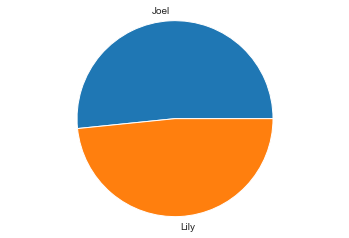

In [172]:
# Pie chart displaying number of messages sent per person

convo.get_sender_breakdown_pie()

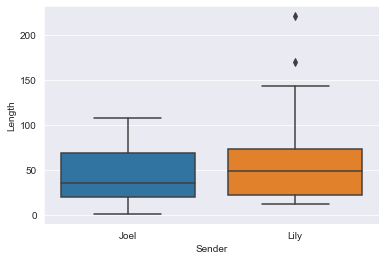

In [173]:
# Box plot showing the IQR and range of message lengths

convo.get_msg_length_distribution()

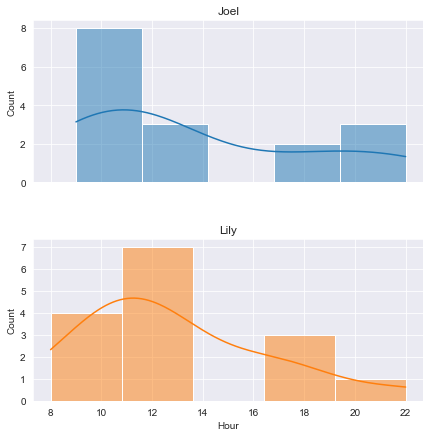

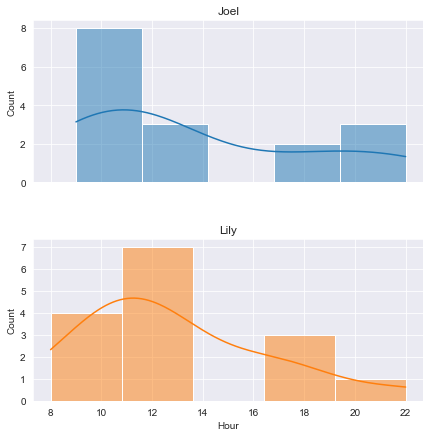

In [174]:
# Histogram showing the time (hour) of messages sent

convo.get_msg_send_time_distribution()

In [175]:
# Finding the number of each emoji each person uses

emoji_dict = convo.get_most_common_emojis()
print(convo.display_most_common_emojis(emoji_dict))

Joel: 👌 (3), 😂 (2), 😍 (2), 😭 (1), 😢 (1) 
Lily: 😂 (12), 😁 (4), 🥰 (3), 🤷 (1), 🏻 (1) 



In [176]:
# Finding the average numer of emojis used per message

print(convo.display_number_of_emojis_per_message())

Joel: (11 total emojis)/(16 total messages) = 0.7 
Lily: (28 total emojis)/(15 total messages) = 1.9 



With the foundations in place, you can now adapt this to produce more analysis as required. See [www.joelpointon.com](www.joelpointon.com) for more information on my work.